In [1]:
import numpy as np
import csv
import cv2
import random
import matplotlib.pylab as plt
%matplotlib inline
from data_adaptation import *

In [2]:
data_folder = '../CarND-Data-P3/data_all/'
read_lines = []
bins = 250
samples_per_bin = 60

with open(data_folder + 'driving_log.csv') as csv_file:
    reader = csv.reader(csv_file)
    for line in reader:
        read_lines.append(line)
lines = np.array(read_lines[1:])

In [3]:
print('Total data lines from driving data: ', len(lines))
print('That makes a total data points after augmentation: ', 6 * len(lines))

Total data lines from driving data:  31502
That makes a total data points after augmentation:  189012


In [4]:
angles_list = []
for line in lines:
    angles_list.append(float(line[3].strip()))
angles = np.array(angles_list)

<a list of 250 Patch objects>

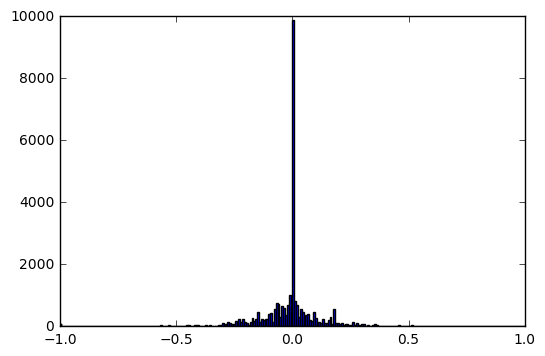

In [5]:
hist_original = plt.hist(angles, bins = bins)
hist_original[2]

In [6]:
used_samples = []
# make use extremes are included
hist_original[1][-1] += 0.0000001
bin_start = min(angles)
for bin_end in hist_original[1][1:]:
    selectable = np.where(np.logical_and(angles >= bin_start, angles < bin_end))
    samples_in_bin = len(angles[selectable])
    if samples_in_bin > samples_per_bin:
        idx = np.random.choice(samples_in_bin, samples_per_bin, replace=False)
        select_from = lines[selectable]
        used_samples.append(select_from[idx])
    else:
        used_samples.append((lines[selectable]))
    bin_start = bin_end
used_samples = np.concatenate(used_samples)

In [7]:
angles_list = []
for line in used_samples:
    angles_list.append(float(line[3].strip()))
used_angles = np.array(angles_list)

<a list of 250 Patch objects>

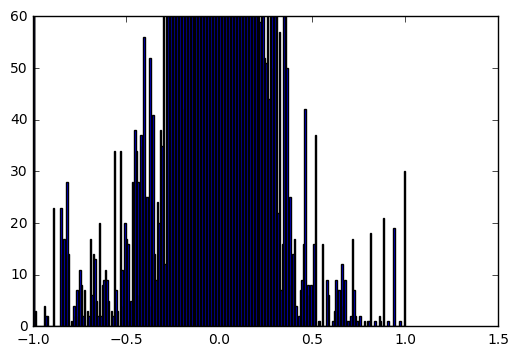

In [8]:
hist_mod = plt.hist(used_angles, bins = hist_original[1])
hist_mod[2]

In [9]:
print('Lines available after selection:', len(used_samples))
print('Samples available after selection:', len(used_samples) * 6)

Lines available after selection: 6319
Samples available after selection: 37914


In [ ]:
def generate_train_data(train_lines, data_folder, batch_size):
    while 1:
        x_out = []
        y_out = []
        # shuffle samples to use
        #np.random.shuffle(train_lines)
        for select_sample in range(batch_size):
            # select a line
            line = train_lines[ np.random.randint(0,len(train_lines))]
            X_train, y_train = get_training_data([line], data_folder)
            # select randomly from center, left, right or mirrored
            s = np.random.randint(0,6)
            x_out.append(X_train[s])
            y_out.append(y_train[s])
        X_train_batch = np.array(x_out)
        y_train_batch = np.array(y_out)
        yield X_train_batch, y_train_batch

In [ ]:
def generate_val_data(val_lines, data_folder):
    while 1:
        # shuffle samples to use
        np.random.shuffle(val_lines)
        for line in val_lines:
            center_file = line[0].split('/')[-1]
            center_image = cv2.imread(data_folder + 'IMG/' + center_file.strip())
            angle = np.array([[float(line[3])]])
            yield center_image[None, :, :, :], angle

From here on I'm going to overtrain a model to check it.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

In [ ]:
model = Sequential()
model.add(Cropping2D(cropping=((55, 20), (0, 0)), input_shape=(160, 320, 3)))
model.add(Lambda(lambda x: x/127.5 - 1., ))
model.add(Convolution2D(16, (8, 8), strides=(4, 4), padding="same", input_shape=(160, 320, 3)))
model.add(ELU())
model.add(Convolution2D(32, (5, 5), strides=(2, 2), padding="same"))
model.add(ELU())
model.add(Convolution2D(64, (5, 5), strides=(2, 2), padding="same"))
model.add(Flatten())
# I'm taking out mechanism to avoid overfitting, this time, overfit.
#model.add(Dropout(.2))
model.add(ELU())
#model.add(Dense(512, kernel_initializer='glorot_normal', kernel_regularizer=l2(0.001)))
model.add(Dense(512, kernel_initializer='glorot_normal'))
#model.add(Dropout(.5))
model.add(ELU())
model.add(Dense(1))

model.compile(optimizer="adam", loss="mse")
#model.fit(X_train, y_train, batch_size=32, validation_split=0.3, shuffle=True, epochs=50, callbacks=[saving])

In [ ]:
np.random.shuffle(used_samples)
val_lines = max(1 ,int(len(used_samples) * 0.3))
validation = used_samples[:val_lines]
training = used_samples[int(len(used_samples) * 0.3):]
print('Size of training set lines:', len(training))
print('size of validation set lines:', len(validation))

In [ ]:
print('Size of training set frames:', len(training) * 6)
print('size of validation set frames:', len(validation))
batch_size = min(2048, len(training) * 6)
train_gen = generate_train_data(training, data_folder, batch_size) # minimum batch size is 1 line, equivalently 6 samples
val_gen = generate_val_data(validation, data_folder)

In [ ]:
X_train, y_train = get_training_data(used_samples, data_folder)
model.fit(X_train, y_train, batch_size=32, validation_split=0.3, shuffle=True, epochs=100, verbose=1)

In [ ]:
n = 3
m = 2
fig, ax = plt.subplots(n, m)
for a, sample, angle in zip(ax.flatten(), X_train, y_train):
    #img = cv2.imread(data_folder + sample[0].strip())
    # Crop images to see what the classifiers sees
    #a.imshow(toRGB(img[:, :, :]))
    a.imshow(sample)
    steer_estimate = model.predict(sample[None,:,:,:], batch_size=1)[0][0]
    a.set_title('Steer angle: ' + str(angle) + '\n' + 'Estimated angle: ' + str(steer_estimate) + '\n' +
                'error: ' + str(abs(angle - steer_estimate)))
fig.set_size_inches(10,8)
fig.tight_layout()

In [ ]:
np.random.randint(0,6)

In [ ]:
total_samples = len(training) * 6
steps_epoch = total_samples // batch_size  # uncomment this to loop through all samples in selected samples
print('Proccesing', batch_size, 'frames on each batch')
print('Proccesing ', steps_epoch, 'batches on each epoch')
model.fit_generator(generator=train_gen, steps_per_epoch=steps_epoch, validation_data=val_gen,
                    validation_steps=len(validation), epochs=100, verbose=1)
model.save('commaai_overfit')

In [ ]:
n = 3
m = 3
fig, ax = plt.subplots(n, m)
for a, sample in zip(ax.flatten(), training):
    img = cv2.imread(data_folder + sample[0].strip())
    # Crop images to see what the classifiers sees
    a.imshow(toRGB(img[:, :, :]))
    steer_estimate = model.predict(toRGB(img)[None,:,:,:], batch_size=1)[0][0]
    a.set_title('Steer angle: ' + sample[3] + '\n' + 'Estimated angle: ' + str(steer_estimate) + '\n' +
                'error: ' + str(abs(float(sample[3]) - steer_estimate)))
fig.set_size_inches(10,8)
fig.tight_layout()